# 🗃️ CSV Dosyalarını PostgreSQL Veritabanına Otomatik Yükleme

Bu notebook, belirttiğiniz klasörde yer alan `.csv` dosyalarını tarayarak her birini PostgreSQL veritabanına uygun şekilde tabloya dönüştürür ve verileri yükler.

---

## 🧩 Adım Adım Süreç:

### 🔗 1. Veritabanı Bağlantısı
- PostgreSQL veritabanına bağlanılır.
- Bağlantı bilgileri `dbname`, `user`, `password`, `host`, `port` ile sağlanır.

### 📂 2. CSV Dosyalarının Tarama ve Okunması
- Belirtilen klasördeki tüm `.csv` dosyaları listelenir.
- Her dosya `pandas` ile `;` (noktalı virgül) ayracıyla okunur.
- Hatalı satırlar atlanır (`on_bad_lines='skip'`).

### 🧹 3. Sütun İsimleri Temizlenir
- Geçersiz karakterler (`.` ve boşluk) `_` ile değiştirilir.

### 🧱 4. PostgreSQL Tablosunun Oluşturulması
- Her dosya için ayrı bir tablo oluşturulur (dosya adı = tablo adı).
- Pandas veri tipleri PostgreSQL veri tiplerine çevrilir (`INTEGER`, `FLOAT`, `TEXT`, `BOOLEAN`, `TIMESTAMP`).

### 📊 5. Verilerin Yüklenmesi
- Her satır tabloya `INSERT INTO` ile eklenir.
- Hatalı satırlar atlanır ama işlem devam eder.

### ✅ 6. İşlem Sonu
- Tüm işlemler tamamlandıktan sonra veritabanı bağlantısı kapatılır.

---

## 🖼️ Örnek: Veritabanı İçeriği ve Tablo Yapısı

Aşağıdaki görselde `public` şemasına ait 5 tablo (Household, Profile, Trip, Trip_Leg, Vehicle_ownership) görüntülenmektedir:

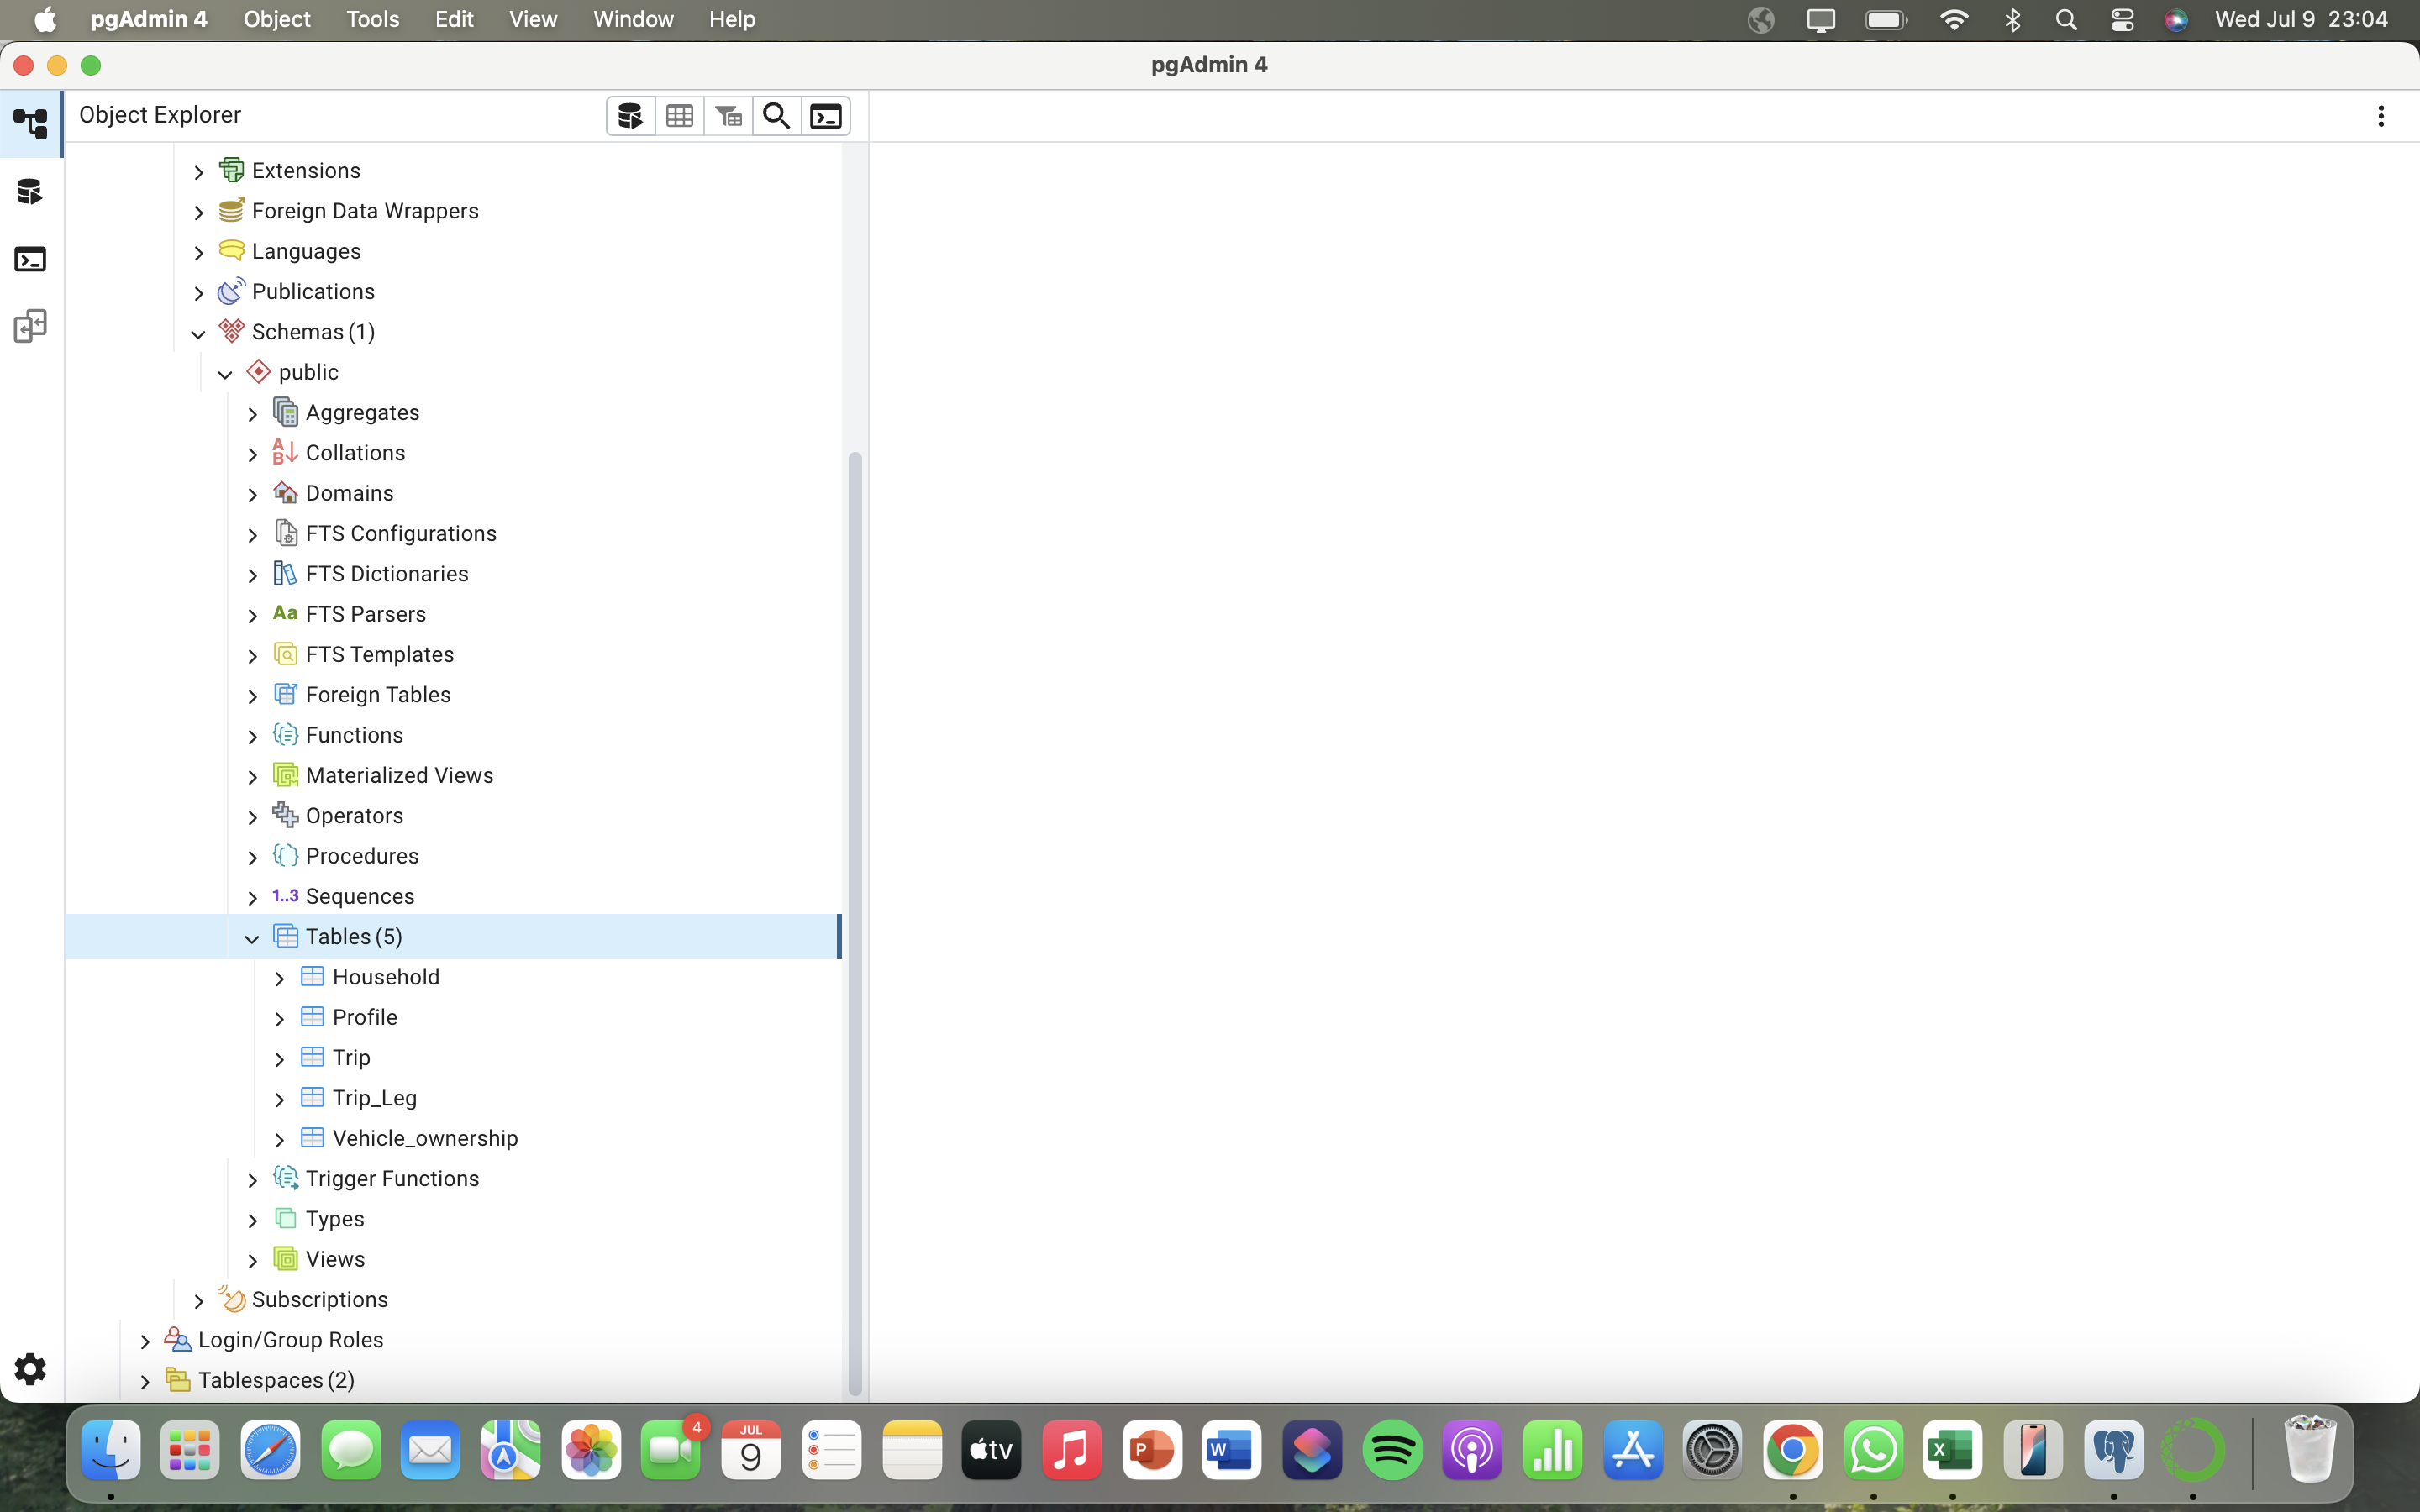

> Bu yapı PostgreSQL'e yüklenen CSV tablolarının nasıl organize edildiğine dair örnek sunar.

---

## 🔔 Notlar:
- CSV dosyaları `;` ile ayrılmış olmalıdır.
- Pandas tarafından okunamayan satırlar sessizce atlanır.
- Tablo oluşturma işlemi `IF NOT EXISTS` içerir, bu nedenle tekrar çalıştırıldığında hata vermez.


In [1]:
import psycopg2
import pandas as pd
import os

# Veritabanı bağlantı bilgileri
database_name = 'postgres'
database_users = 'postgres'
password = '1412'
host = 'localhost'
host_port = '5432'

# Veritabanına bağlan
conn = psycopg2.connect(
    dbname=database_name,
    user=database_users,
    password=password,
    host=host,
    port=host_port
)
cursor = conn.cursor()
print("✅ Veritabanına bağlanıldı.")

# CSV dosyalarının bulunduğu klasör
csv_folder_path = '/Users/melihanileroglu/Downloads/Model Veri Seti/CSV/'

# Tüm CSV dosyalarını listele
csv_files = [f for f in os.listdir(csv_folder_path) if f.endswith('.csv')]

# Veri tipi dönüşüm fonksiyonu
def get_postgres_dtype(pandas_dtype):
    if pd.api.types.is_integer_dtype(pandas_dtype):
        return 'INTEGER'
    elif pd.api.types.is_float_dtype(pandas_dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(pandas_dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(pandas_dtype):
        return 'TIMESTAMP'
    else:
        return 'TEXT'

for csv_file in csv_files:
    csv_file_path = os.path.join(csv_folder_path, csv_file)
    
    print(f"📂 İşleniyor: {csv_file}")

    # CSV dosyasını oku (noktalı virgül ile ayrılmış)
    try:
        df = pd.read_csv(csv_file_path, sep=';', low_memory=False, on_bad_lines='skip')
    except Exception as e:
        print(f"⚠️ Hata oluştu: {csv_file} - {e}")
        continue  # Hatalı dosyayı atla, sonraki dosyaya geç

    # Sütun isimlerini temizle (geçersiz karakterleri kaldır)
    df.columns = [col.replace('.', '_').replace(' ', '_') for col in df.columns]

    # Dosya adını tablo adı olarak kullan (uzantıyı kaldır)
    table_name = os.path.splitext(csv_file)[0]

    # Tabloyu oluştur
    create_table_query = f'''
    CREATE TABLE IF NOT EXISTS "{table_name}" (
        {', '.join([f'"{col}" {get_postgres_dtype(df[col].dtype)}' for col in df.columns])}
    );
    '''
    cursor.execute(create_table_query)
    conn.commit()
    print(f"✅ Tablo oluşturuldu: {table_name}")

    # Verileri tabloya ekle
    for _, row in df.iterrows():
        insert_query = f'''
        INSERT INTO "{table_name}" ({', '.join([f'"{col}"' for col in df.columns])})
        VALUES ({', '.join(['%s' for _ in row])});
        '''
        try:
            cursor.execute(insert_query, tuple(row))
        except Exception as e:
            print(f"⚠️ Veri eklerken hata oluştu: {e}")
            continue  # Hatalı satırı atla

    conn.commit()
    print(f"📊 CSV verisi '{table_name}' tablosuna başarıyla yüklendi.")

# Bağlantıyı kapat
conn.close()
print("✅ Veritabanı bağlantısı kapatıldı.")


✅ Veritabanına bağlanıldı.
📂 İşleniyor: Household.csv
✅ Tablo oluşturuldu: Household
📊 CSV verisi 'Household' tablosuna başarıyla yüklendi.
📂 İşleniyor: Profile.csv
✅ Tablo oluşturuldu: Profile
📊 CSV verisi 'Profile' tablosuna başarıyla yüklendi.
📂 İşleniyor: Trip.csv
✅ Tablo oluşturuldu: Trip
📊 CSV verisi 'Trip' tablosuna başarıyla yüklendi.
📂 İşleniyor: Vehicle_ownership.csv
✅ Tablo oluşturuldu: Vehicle_ownership
📊 CSV verisi 'Vehicle_ownership' tablosuna başarıyla yüklendi.
📂 İşleniyor: Trip_Leg.csv
✅ Tablo oluşturuldu: Trip_Leg
📊 CSV verisi 'Trip_Leg' tablosuna başarıyla yüklendi.
✅ Veritabanı bağlantısı kapatıldı.
